# Tutorial 3b: Analysis of Boolean data

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t3a_boolean_data.ipynb).  Meaghan Sullivan provided some of the background information for this tutorial.*

In [1]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

/Users/Justin/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In this tutorial, we analyze Boolean, or "coin flip" data to estimate the probability that the outcome is True, or the "bias of the coin."  That is to say, we will estimate the probability $p$ that a coin lands heads, given a series of coin flips.

Many experiments we encounter in biology.  A "coin flip" is any measurement that has a yes (heads) or no (tails) answer.

## Background
The data we will use comes from an experiment we did last spring in [Bi 1x](http://bi1x.caltech.edu/) here at Caltech.  We studies a neural circuit in *C. elegans* using optogenetics.

A neural circuit is a series of interconnected neurons that create a pathway to transmit a signal from where it is received, to where it causes a behavioral response in an animal.  An example is the neural circuit involved in reversals in *C. elegans*.  This circuit consists of three types of neurons: sensory neurons receive stimuli from the environment, command interneurons integrate information from many sensory neurons and pass a signal to the motor neurons, and motor neurons control worm behavior, such as reversals.

There are six neurons acting in a circuit that responds to environmental cues and triggers a reversal, a shown in the figure below (based on [Schultheis et. al. 2011](10.1371/journal.pone.0018766)).  These include four sensory neurons (ALM, AVM, ASH, and PLM).  Each sensory neuron is sensitive to a different type of stimulus.  For example, the sensory neuron we are studying (ASH) is sensitive to chemosensory stimuli such as toxins, while another neuron (PLM) is sensitive to mechanical stimuli (touch) in the posterior part of the worm's body.  The sensory neurons send signals that are integrated by two command interneurons (AVA and AVD).  Each sensory neuron can provide an impulse to the command interneurons at any time.  In order for the command interneuron to fire and activate motor neurons, the sum of the stimuli at any point in time must exceed a certain threshold.  Once the stimuli from one or more sensory neurons has induced an action potential in a command interneuron, that signal is passed to motor neurons which will modulate worm behavior.

![Reversal neural network](reversal_neural_network.png)

In the experiment, we used optogenetics to dissect the function of individual neurons in this circuit.  We worked with two optogenetic worm strains.  The ASH strain has channelrhodopsin (ChR2, represented by a red barrel in the figure above) expressed only in the ASH sensory neuron.  When we shine blue light on this strain, we should activate the ChR2, which will allow sodium and calcium cations to flow into the neuron, simulating an action potential. 
We want to quantify how robustly this stimulation will cause the worm to exhibit aversion behavior and reverse.  

We will worked with an AVA strain that has channelrhodopsin expressed only in the AVA command interneuron.  Our goal is to quantify the effects of stimulating this neuron in terms of reversals compared to the ASH neuron and to wild type.

In the analog to the coin flip problem, "heads" is a reversal and "tails" is a non-reversal upon exposure to blue light.  We will estimate $p$, the probability of reversal after exposure to blue light.

## Bayesian estimation of $p$
Our goal is to estimate the probability of reversal, given an observed sequence of trials wherein the worm either reverses or does not.  The probability of reversal is a parameter in a model (model 3), and we need to derive the appropriate likelihood and prior for this model.  Remember, we want to find the posterior

\begin{align}
P(p\mid D, I) = \frac{P(D\mid p, I)\,P(p \mid I)}{P(D \mid I)}.
\end{align}

### The likelihood
Let's start with the likelihood.  We will build an expression for $P(D\mid p, I)$.  First, what is $D$?  $D$ is the list of the results of all trials for a given strain.  If we assume that each trial is independent of all others, then the order of the trials does not matter.  We then only need to consider the number of reversals and the total number of trials.  We will define these quantities to be $n_r$ and $n$, respectively.

Now, what is $P(n_r \mid n, p, I)$?  Imagine that trail number 1 showed a reversal.  The probability that this happens is $p$.  Now, imagine that trail number 2 also showed a reversal.  The probability that trials 1 and 2 went this way is $p^2$, since the trials are independent.  Now, imagine trial 3 did not show a reversal.  The probability of trails 1, 2, and 3 going this way is $p^2(1-p)$, since the probability of *not* showing a reversal is $1-p$.  So, we can see that a *given sequence* of $n$ trails that show $n_r$ reversals occurs with probability $p^{n_r}(1-p)^{n-n_r}$.  But, this is just one of many sets of trials that can occur with $n_r$ reversals.  How many ways are there to have $n_r$ out of $n$ reversals?  The answer is given by the **binomial coefficient**.

\begin{align}
\begin{pmatrix}
n \\ n_r
\end{pmatrix} = \frac{n!}{n_r!\,(n-r)!},
\end{align}

pronounced "$n$ choose $n_r$."  So, our likelihood is given by the **binomial distribution**,

\begin{align}
P(n_r \mid n, p, I) = \frac{n!}{n_r!\,(n-r)!} p^{n_r}(1-p)^{n-n_r}.
\end{align}

With our new representation of $D$, we can re-write the posterior as

\begin{align}
P(p\mid n_r, n, I) = \frac{P(n_r \mid n, p, I)\,P(p \mid n, I)}{P(n_r \mid n, I)}.
\end{align}


### The prior
The prior distribution is what we know about the worm before any trials.  We will assume we know *nothing*!  So, there is equal probability that $p$ takes any value between zero and one, so

\begin{align}
P(p\mid n, I) = \left\{ \begin{array}{ccc}
1 & & 0 \le p \le 1 \\
0 & & \text{otherwise}.
\end{array}\right.
\end{align}

### The evidence
Finally, $P(n_r\mid n, I)$ does not matter to us because it does not depend on $p$ (the thing we are trying to find out), and it is only a constant of proportionality determined by the fact that the posterior distribution must be normalized.  However, knowing the normalization constant is useful for plotting the posterior for various values of $n_r$ because we want to compare normalized distributions.

We can use our intuition about $P(n_r\mid n, I)$ to evaluate an otherwise difficult integral for the normalization constant.  Remember that $P(n_r \mid n, I)$ is the probability distribution for the number of reversals knowing nothing about the worm.  In this case, all possible numbers of reversals in $n$ trials should be equally likely.  Because we could see zero reversal, there are $n+1$ possibilities.  So, $P(n_r\mid n, I) = 1/(n+1)$.  We then have our normalized posterior,

\begin{align}
P(p\mid n_r, n, I) = \left\{ \begin{array}{ccc}
{\displaystyle \frac{(n+1)!}{(n-n_r)!\,n_r!}\,p^{n_r}(1-p)^{n-n_r}} & & 0 \le p \le 1 \\[1em]
0 & & \text{otherwise}.
\end{array}\right.
\end{align}

So, we are done.  We have an analytical expression for our posterior!  We need only to know the number of reversals, $n_r$ our of $n$ trials.

## The data set
As mentioned above, we worked with one strain containing channelrhodopsin on the AVA neuron and another with the channelrhodopsin on the ASH neuron.  We also tested wild type worms for reversals.

For this experiment, each group of students conducted three experiments on each of the three strains of worms and recorded reversals.  The data are contained in the file [`bi1x_2015_c_elegans_optogenetics.csv`](../data/bi1x_2015_c_elegans_optogenetics.csv).  Be sure to read the header comments.  Specifically, if a worm reversed upon exposure to blue light, it is scored with a "`1`."  If it did not reverse, it was scored with a "`0`."  Finally, if the worm was lost (many were freshmen, after all), it was scored with a "`-1`."

In [2]:
# Load in data from csv file
df = pd.read_csv('bi1x_2015_c_elegans_optogenetics.csv', comment='#')

# Take a look
df.head()

,Group,Worm,WT,AVA,ASH
0,Group B1,worm 1,0,1,1
1,Group B1,worm 2,0,1,0
2,Group B1,worm 3,0,1,0
3,Group B2,worm 1,0,1,0
4,Group B2,worm 2,0,1,0


Just because it's good practice, and habit by now, we'll tidy the data.

In [3]:
# Tidy!
df = pd.melt(df, id_vars=['Group', 'Worm'], value_vars=['WT', 'AVA', 'ASH'], 
             value_name='reversal', var_name='strain')

# Take a look
df.head()

,Group,Worm,strain,reversal
0,Group B1,worm 1,WT,0
1,Group B1,worm 2,WT,0
2,Group B1,worm 3,WT,0
3,Group B2,worm 1,WT,0
4,Group B2,worm 2,WT,0


## Computing the posteriors
To compute the posteriors, we just need to pull $n_r$ and $n$ out for each strain and then use our analytical expression for the posterior.  We can write a function to compute $n_r$ and $n$ from the `DataFrame`.

In [4]:
def revs_trials(df, strain):
    """
    Return number of reversals and number of trails.
    """
    inds = (df['strain'] == strain) & (df['reversal'] >= 0)
    n_r = df[inds]['reversal'].sum()
    n = df[inds]['reversal'].count()
    
    return n_r, n

Next, we'll write a function to compute the posterior.  We have to be careful, as usual, and compute the log of the posterior first and then exponentiating.  This avoids over and underflow errors.  In particular, we need to compute the logarithms of factorials.  It is useful to know that $n! = \Gamma(n+1)$, where $\Gamma(x)$ denotes the gamma function.  There is a convenient function to computing the logarithm of the gamma function, `scipy.special.gammaln()`.

In [5]:
def log_posterior(n_r, n, p):
    """
    Log posterior of reversal measurements.
    """
    return scipy.special.gammaln(n+2) - scipy.special.gammaln(n_r + 1) \
              - scipy.special.gammaln(n - n_r + 1) \
              + n_r * np.log(p) + (n - n_r) * np.log(1 - p)

Now we can compute and plot the posteriors for all three strains.

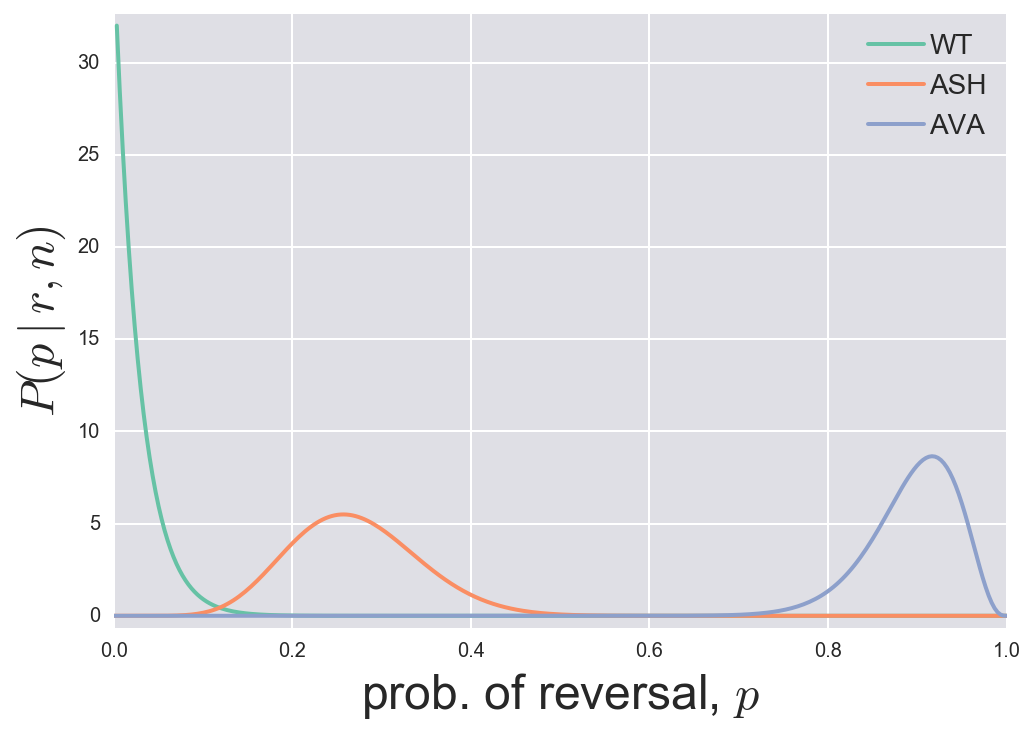

In [8]:
# Values of p for plot
p = np.linspace(0, 1, 300)
colors = sns.color_palette("Set2", 10)

# Make plots
strains = ['WT', 'ASH', 'AVA']  
for i, strain in enumerate(strains):
    n_r, n = revs_trials(df, strain)
    plt.plot(p, np.exp(log_posterior(n_r, n, p)), '-', color=colors[i])

# Pretty it up
plt.margins(y=0.02)
plt.xlabel('prob. of reversal, $p$', fontsize=24)
plt.ylabel(r'$P(p\mid r, n)$', fontsize=24)
plt.legend(strains, loc='upper right', fontsize=14)

From the plot of the posteriors, we see that the the chance of reversal of the AVA strain upon exposure to blue light is almost certainly above 70%, while the chance of reversal for the ASH strain is almost certainly below 50%.  The wild type chance of reversal is almost certainly below 20%, but there is some chance that it might have a higher chance of reversal than the ASH strain.

## Comparison of two reversal probabilities
The posterior plots above are illuminating, but suppose we want to quantify *the difference* in reversal probability between the two strains, say strain 1 and strain 2.  That is, we want to compute $P(\delta\mid D, I)$, where $\delta \equiv p_2 - p_1$.  To compute this distribution, we use the fact that we can easily compute the joint probability distribution because the two strains are independent.  To ease notation, we will note that the prior $P(p_1, p_2\mid I)$ is only nonzero if $0\le p_1,p_2 \le 1$, instead of writing it explicitly.  The posterior is

\begin{align}
P(p_1, p_2\mid D, I) &= 
\frac{(n_1+1)!\,(n_2+1)!}{(n_1-n_{r1})!\,n_{r1}!\,(n_2 - n_{r2})!\,n_{r2}!} \\[0.5em]
&\;\;\;\;\;\;\;\;\times\,p_1^{n_{r1}}\,(1-p_1)^{n_1-n_{r1}}\,p_2^{n_{r2}}\,(1-p_2)^{n_2-n_{r2}}.
\end{align}


We can define new variables $\delta = p_2 - p_1$ and $\gamma = p_1 + p_2$.  Then, we have $p_1 = (\gamma - \delta) / 2$ and $p_2 = (\gamma + \delta) / 2$. 
Again, to ease notation, we note that $P(\gamma, \delta\mid D, I)$ is nonzero only when $-1 \le \delta \le 1$ and $|\delta| \le \gamma \le 2 - |\delta|$.  By the change of variables formula for probability distributions we have

\begin{align}
P(\gamma, \delta \mid D, I) =
\begin{vmatrix}
\mathrm{d}p_1/\mathrm{d}\gamma & \mathrm{d}p_1/\mathrm{d}\delta \\
\mathrm{d}p_2/\mathrm{d}\gamma & \mathrm{d}p_2/\mathrm{d}\delta
\end{vmatrix}
P(p_1, p_2 \mid n_{r1}, n_{r2}, n_1, n_2, I)
= \frac{1}{2}\,P(p_1, p_2 \mid D, I).
\end{align}

Thus, we have

\begin{align}
P(\gamma, \delta\mid D, I) &= \frac{(n_1+1)!\,(n_2+1)!}{2(n_1-n_{r1})!\,(n_2-n_{r2})!\,n_1!\,n_2!} \\
&\;\;\;\;\times 
\left(\frac{\gamma-\delta}{2}\right)^{n_{r1}}\,\left(1-\frac{\gamma-\delta}{2}\right)^{n_1-n_{r1}} \left(\frac{\gamma+\delta}{2}\right)^{n_{r2}}\,\left(1-\frac{\gamma+\delta}{2}\right)^{n_2-n_{r2}}.
\end{align}

Finally, to find $P(\delta\mid D, I)$, we marginalize by integrating over all possible values of $\gamma$.

\begin{align}
P(\delta\mid D, I) =
\int_{|\delta|}^{2-|\delta|}\mathrm{d}\gamma\, P(\gamma, \delta\mid D, I)
\end{align}

We can expand each of the multiplied terms in the integrand into a polynomial using the binomial theorem, and can then multiply the polynomials together to get a polynomial expression for the integrand.  This can then be integrated.  There is a technical term describing this process: *a big mess*.  This will be a motivation for Markov chain Monte Carlo that we will learn in coming weeks.

### Numerical marginalization
For fun, we will numerically compute the nasty integral we derived above for $P(\delta \mid D, I)$.  We first need to write a function for the joint posterior $P(\delta, \gamma \mid D, I)$.

In [ ]:
def posterior_delta_gamma(delta, gamma, n_r1, n_1, n_r2, n_2):
    """
    Posterior probability distribution for delta and gamma.
    
    Input is arrays delta and gamma.  Returns a 2D array for various 
    values of gamma.
    """
    # Make 2D versions of delta and gamma
    dd, gg = np.meshgrid(delta, gamma)
    
    # First outlawed values of n_r and n
    if  n_r1 > n_1 or n_r2 > n_2:
        return np.zeros_like(dd)
    
    # Initialize output array
    out = np.empty_like(dd)
    
    # Populate zero values based on outlawed deltas and gammas
    out[abs(dd) > 1] = 0
    out[gg < 0] = 0
    out[gg > 2] = 0
    out[(gg <= abs(dd))] = 0
    out[(gg >= (2-abs(dd)))] = 0
    
    # Get indices with nonzero values
    inds = (out != 0)

    # Compute log probability
    log_P = scipy.special.gammaln(n_1 + 2) - scipy.special.gammaln(n_r1 + 1) \
            + scipy.special.gammaln(n_2 + 2) - scipy.special.gammaln(n_r2 + 1) \
            - scipy.special.gammaln(n_1 - n_r1 + 1) \
            - scipy.special.gammaln(n_2 - n_r2 + 1) \
            + n_r1 * np.log((gg[inds] - dd[inds]) / 2) \
            + n_r2 * np.log((gg[inds] + dd[inds]) / 2) \
            + (n_1 - n_r1) * np.log(1 - (gg[inds] - dd[inds]) / 2) \
            + (n_2 - n_r2) * np.log(1 - (gg[inds] + dd[inds]) / 2)
            
    # Populate nonzero values and return
    out[inds] = np.exp(log_P) / 2
    
    return out

We can make a contour plot of this joint distribution.  We'll do it for a comparison between the AVA and ASH strains.

In [ ]:
# Generate gamma and delta for the plot
gamma = np.linspace(0, 2, 200)
delta = np.linspace(-1, 1, 200)

# Make coordinates for contour plots
dd, gg = np.meshgrid(delta, gamma)

# Compute probability
n_r_ash, n_ash = revs_trials(df, 'ASH')
n_r_ava, n_ava = revs_trials(df, 'AVA')
post = posterior_delta_gamma(delta, gamma, n_r_ash, n_ash, n_r_ava, n_ava)

# Plot the contour
plt.contourf(dd, gg, post, cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel(r'$\delta = p_\mathrm{AVA} - p_\mathrm{ASH}$', fontsize=24)
plt.ylabel(r'$\gamma = p_\mathrm{AVA} + p_\mathrm{ASH}$', fontsize=24)
plt.xlim((0.4, 0.9))
plt.ylim((0.9, 1.4))
plt.axes().set_aspect('equal', adjustable='box')

Now, we can integrate over $\gamma$.  We will use the trapezoidal rule, implemented by `np.trapz()`.  The `axis` kwarg lets us specify which variable to integrate over.

In [ ]:
# Integrate over gamma
post_delta = np.trapz(post, x=gamma, axis=0)

# Plot the distribution of delta 
plt.plot(delta, post_delta, '-')
plt.xlabel(r'$\delta = p_\mathrm{AVA} - p_\mathrm{ASH}$')
plt.ylabel(r'$P(\delta \mid D, I)$')
plt.margins(y=0.02)

We do the same for ASH and WT.

In [ ]:
# Generate gamma and delta for the plot
gamma = np.linspace(0, 2, 200)
delta = np.linspace(-1, 1, 200)

# Make coordinates for contour plots
dd, gg = np.meshgrid(delta, gamma)

# Compute probability
n_r_ash, n_ash = revs_trials(df, 'WT')
n_r_ava, n_ava = revs_trials(df, 'ASH')
post = posterior_delta_gamma(delta, gamma, n_r_ash, n_ash, n_r_ava, n_ava)

# Integrate over gamma
post_delta = np.trapz(post, x=gamma, axis=0)

# Plot the distribution of delta 
plt.plot(delta, post_delta, '-')
plt.xlabel(r'$\delta = p_\mathrm{ASH} - p_\mathrm{WT}$')
plt.ylabel(r'$P(\delta \mid D, I)$')
plt.margins(y=0.02)

There is vanishing chance that the wild type is more probable to show a reversal than the ASH strain.  So, it seems that in this experiment, doing about 36 trials for each strain was sufficient to tell the difference between each strain.